# Air Quality Analysis in Beijing


### Data source: Beijing Multi-Site Air Quality Data
### Available at: https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy import stats

In [39]:
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

## 1. Data Collection

In [40]:
data_file = "Beijing_Multisite_air_Quality_data.csv"
data_df = pd.read_csv(data_file)
data_df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [41]:
print(f"DataFrame Shape: {data_df.shape}\n")
data_df.info()

DataFrame Shape: (420768, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       418946 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 54.6+ MB


In [42]:
numeric_columns = data_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = data_df.select_dtypes(include=['object']).columns.tolist()

print(f"{len(numeric_columns)} Numeric columns: {numeric_columns}")
print(f"{len(categorical_columns)} Categorical columns: {categorical_columns}")


15 Numeric columns: ['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
2 Categorical columns: ['wd', 'station']


### Let's check the distribution of the dataset among different stations.


In [43]:
data_df.groupby('station').size().reset_index(name='row_count')

,station,row_count
0,Aotizhongxin,35064
1,Changping,35064
2,Dingling,35064
3,Dongsi,35064
4,Guanyuan,35064
5,Gucheng,35064
6,Huairou,35064
7,Nongzhanguan,35064
8,Shunyi,35064
9,Tiantan,35064


### Since all stations have the same number of data points, we select only the first two stations, Aotizhongxin and Changping, for further analysis.

In [57]:
filtered_df = data_df[data_df['station'].isin(['Aotizhongxin', 'Changping'])]
print(f'Dataframe Shape: {filtered_df.shape}')
filtered_df.head()

Dataframe Shape: (70128, 17)


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


## 2. Data Cleaning

### Create a timestamp column

In [58]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df[['year', 'month', 'day', 'hour']])
filtered_df['day_name'] = filtered_df['timestamp'].dt.day_name()
filtered_df['month_name'] = filtered_df['timestamp'].dt.month_name()

In [86]:
print(f"The data for Aotizhongxin station is {'sorted' if filtered_df[filtered_df.station == 'Aotizhongxin']['timestamp'].is_monotonic_increasing else 'not sorted'} by timestamp.")
print(f"The data for Changping station is {'sorted' if filtered_df[filtered_df.station == 'Changping']['timestamp'].is_monotonic_increasing else 'not sorted'} by timestamp.")


The data for Aotizhongxin station is sorted by timestamp.
The data for Changping station is sorted by timestamp.


### Check for Duplicate Entries

In [59]:
duplicate_count = filtered_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


### Removing non-pollutant columns 

In [60]:
filtered_df.drop(columns=['TEMP','PRES','DEWP','RAIN','wd','WSPM'], inplace=True)

In [61]:
print(f'Dataframe Shape: {filtered_df.shape}')

filtered_numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
filtere_categorical_columns = filtered_df.select_dtypes(include=['object']).columns.tolist()

print(f"{len(filtered_numeric_columns)} Numeric columns: {filtered_numeric_columns}")
print(f"{len(filtere_categorical_columns)} Categorical columns: {filtere_categorical_columns}")

Dataframe Shape: (70128, 14)
10 Numeric columns: ['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
3 Categorical columns: ['station', 'day_name', 'month_name']


### Let's Check if there are any missing values in the filtered dataset.

In [62]:
filtered_df.isnull().sum()

year             0
month            0
day              0
hour             0
PM2.5         1699
PM10          1300
SO2           1563
NO2           1690
CO            3297
O3            2323
station          0
timestamp        0
day_name         0
month_name       0
dtype: int64

### Calculating mean and median differences to assess data distribution for handling missing values.

In [63]:
numerical_filtered_df = filtered_df.select_dtypes(include=['number'])
mean_median_diff = numerical_filtered_df.mean() - numerical_filtered_df.median()
print("Differences between Mean and Median\n", mean_median_diff)

Differences between Mean and Median
 year      -0.337440
month     -0.477070
day       -0.270363
hour       0.000000
PM2.5     24.923797
PM10      23.343914
SO2        8.161992
NO2        7.704624
CO       407.412159
O3        12.159726
dtype: float64


### Mean values greater than medians for PM2.5, PM10, SO2, NO2, CO, and O3 indicate a right-skewed distribution.

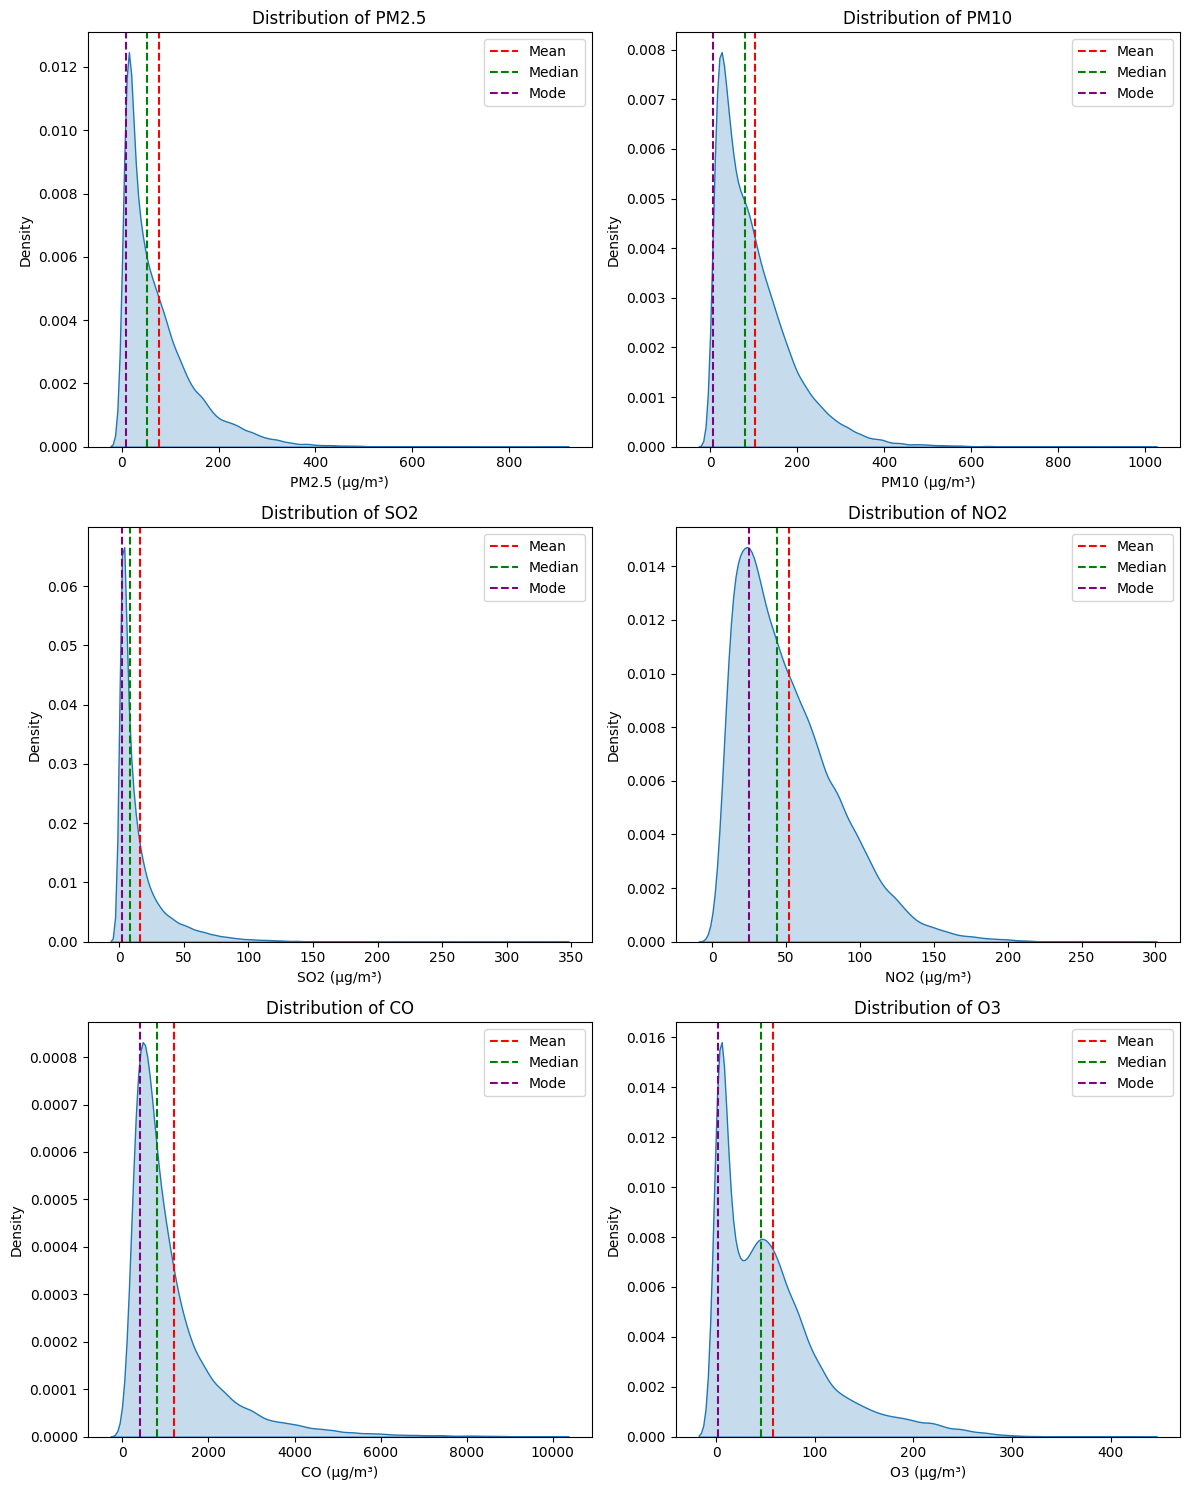

In [64]:
mode = numerical_filtered_df.mode().iloc[0]
mean = numerical_filtered_df.mean()
median = numerical_filtered_df.median()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))  
axes = axes.flatten()

parameters = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

for i, column in enumerate(parameters):
    sns.kdeplot(numerical_filtered_df[column], fill=True, ax=axes[i])
    axes[i].axvline(x=mean[column], color='red', linestyle='--', label='Mean')
    axes[i].axvline(x=median[column], color='green', linestyle='--', label='Median')
    axes[i].axvline(x=mode[column], color='purple', linestyle='--', label='Mode')
    axes[i].set_xlabel(f'{column} (µg/m³)')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Imputing Missing Values: filling with median as it is less influenced by outliers compared to the mean.

In [65]:
filtered_df.fillna({
    'PM2.5': filtered_df['PM2.5'].median(),
    'PM10': filtered_df['PM10'].median(),
    'SO2': filtered_df['SO2'].median(),
    'NO2': filtered_df['NO2'].median(),
    'CO': filtered_df['CO'].median(),
    'O3': filtered_df['O3'].median()
}, inplace=True)

### Outliers
### Identifying outliers of pollutants using the IQR method

In [66]:
outliers_percentage = {}

for pollutant in parameters:

    Q1 = filtered_df[pollutant].quantile(0.25)
    Q3 = filtered_df[pollutant].quantile(0.75)
    
    # Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define outliers: below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = filtered_df[(filtered_df[pollutant] < lower_bound) | (filtered_df[pollutant] > upper_bound)]
    
    outliers_percentage[pollutant] = (len(outliers) / len(filtered_df)) * 100

for pollutant, percentage in outliers_percentage.items():
    print(f"{pollutant}: {percentage:.2f}% of values are outliers")


PM2.5: 5.07% of values are outliers
PM10: 3.62% of values are outliers
SO2: 9.48% of values are outliers
NO2: 1.84% of values are outliers
CO: 8.36% of values are outliers
O3: 4.60% of values are outliers


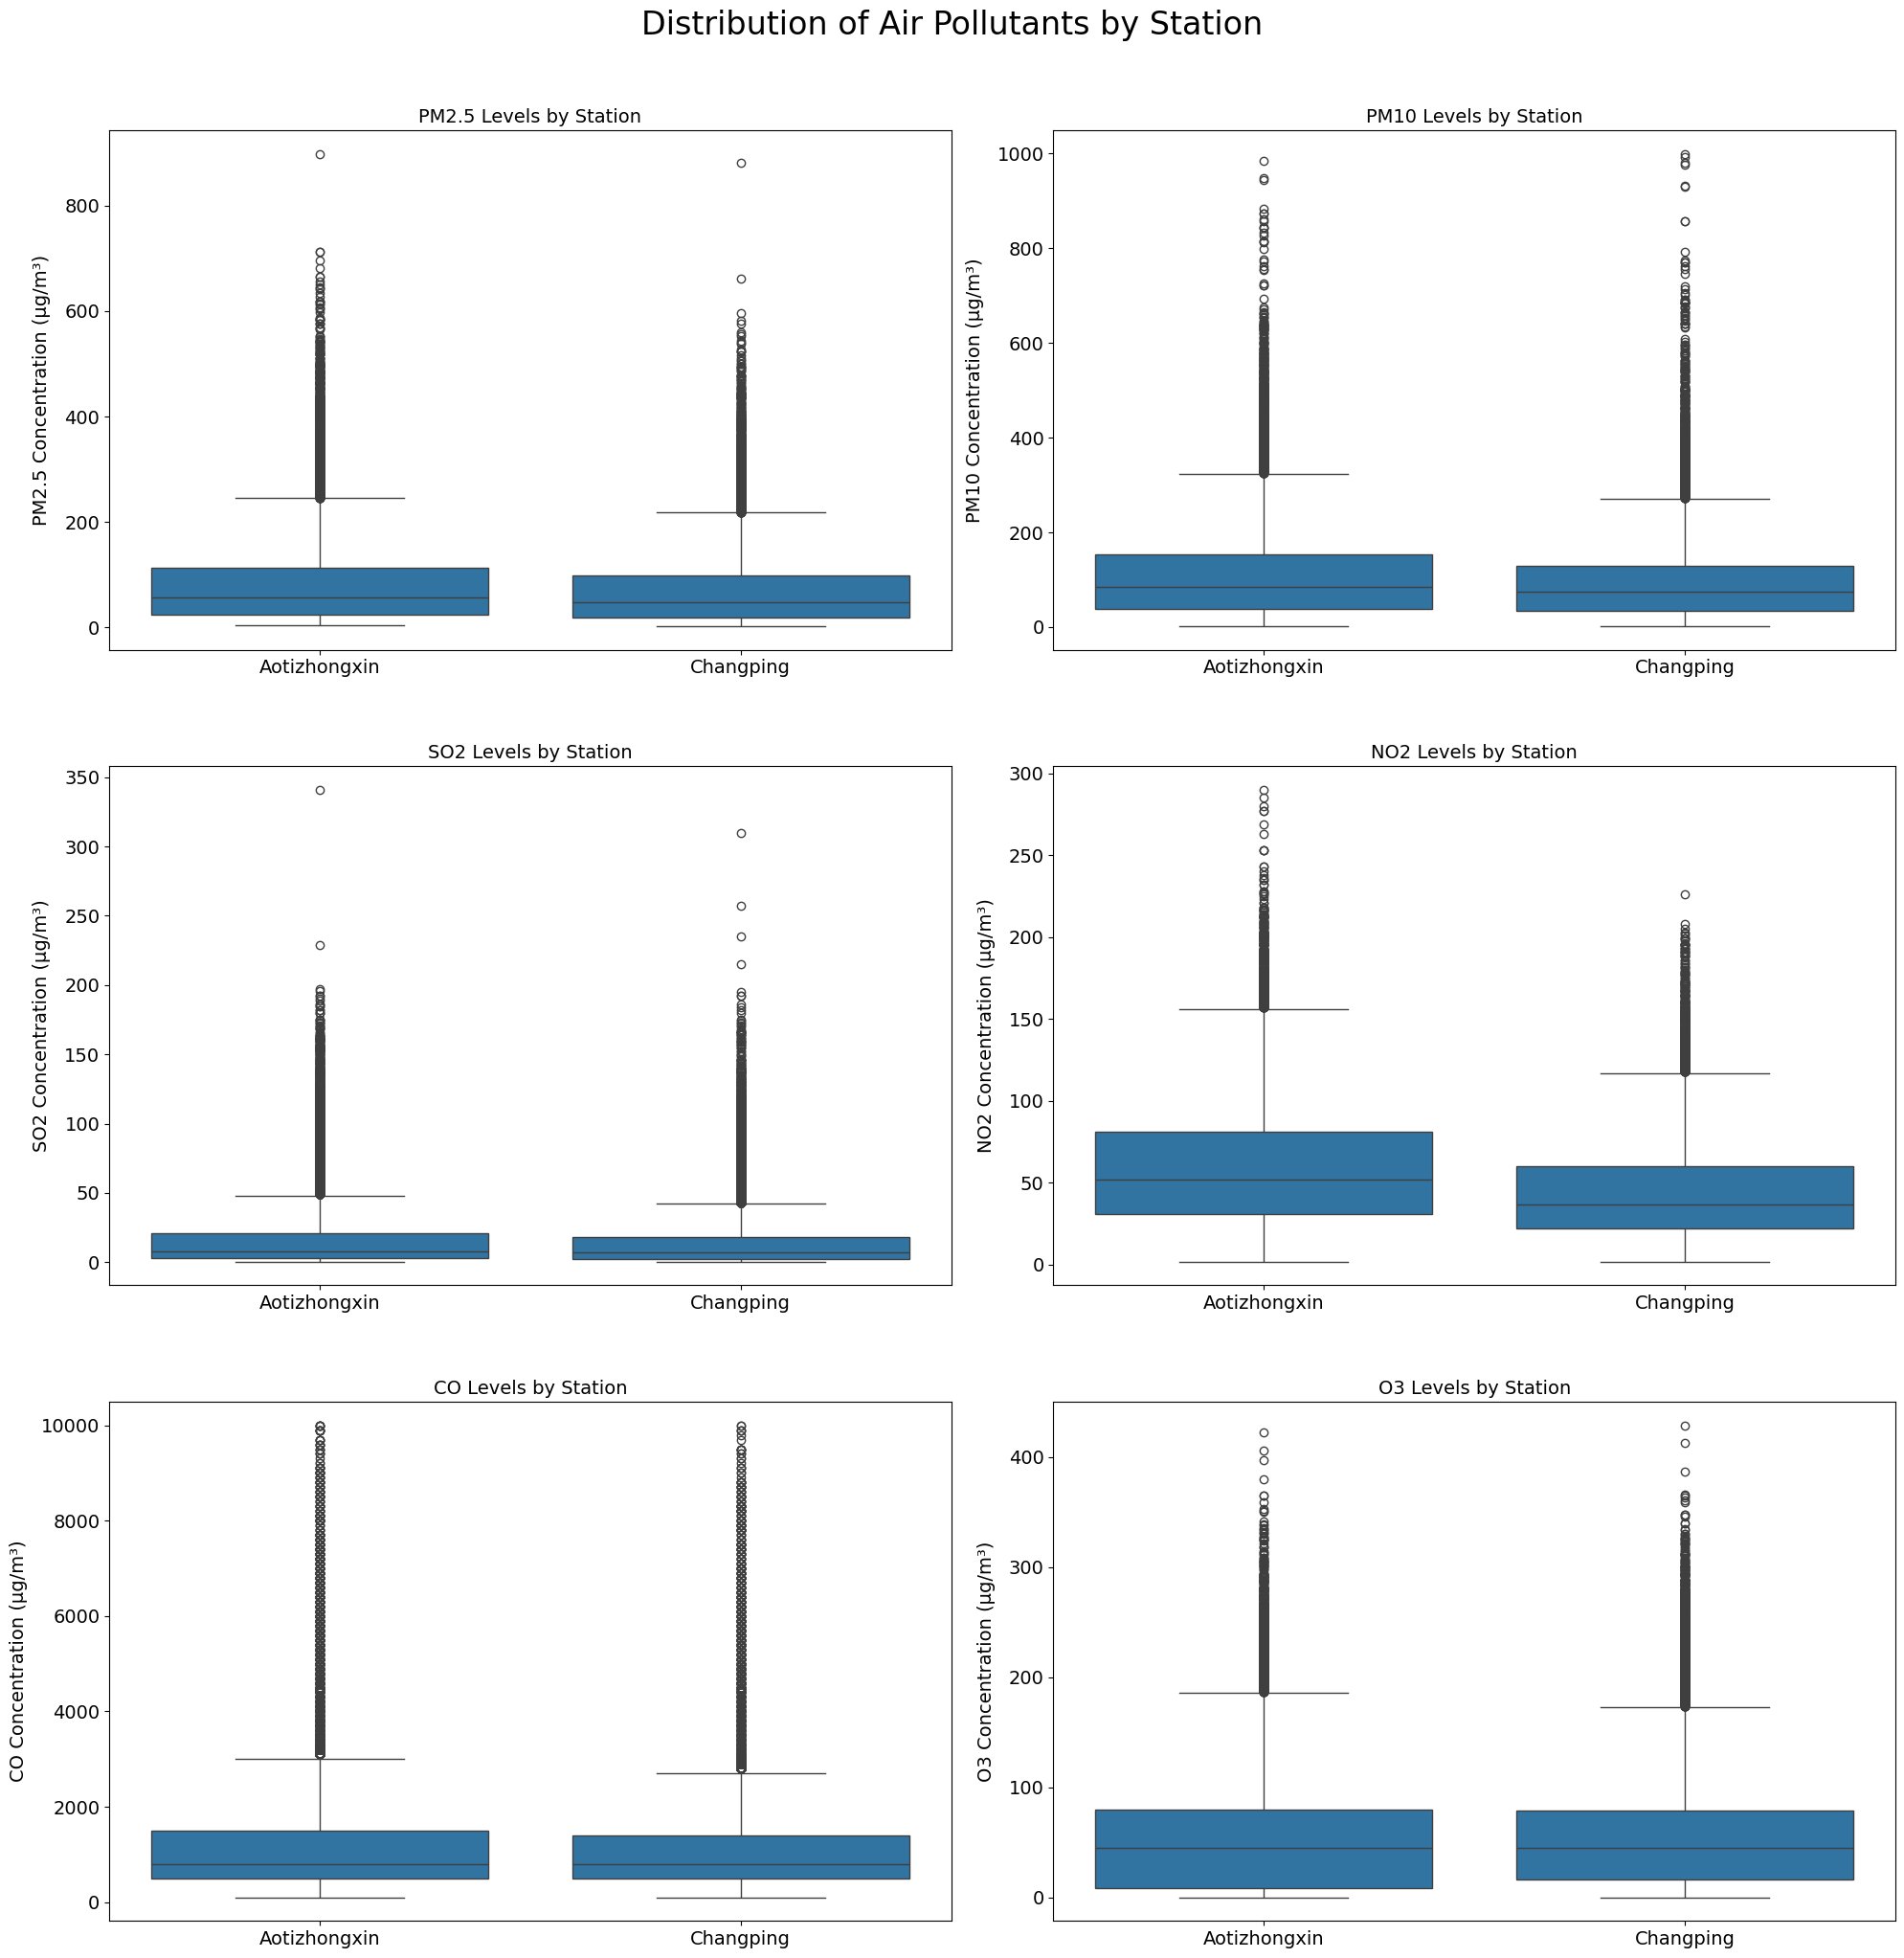

In [67]:
stations = filtered_df['station'].unique()

plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='station', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Station', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.suptitle('Distribution of Air Pollutants by Station', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()

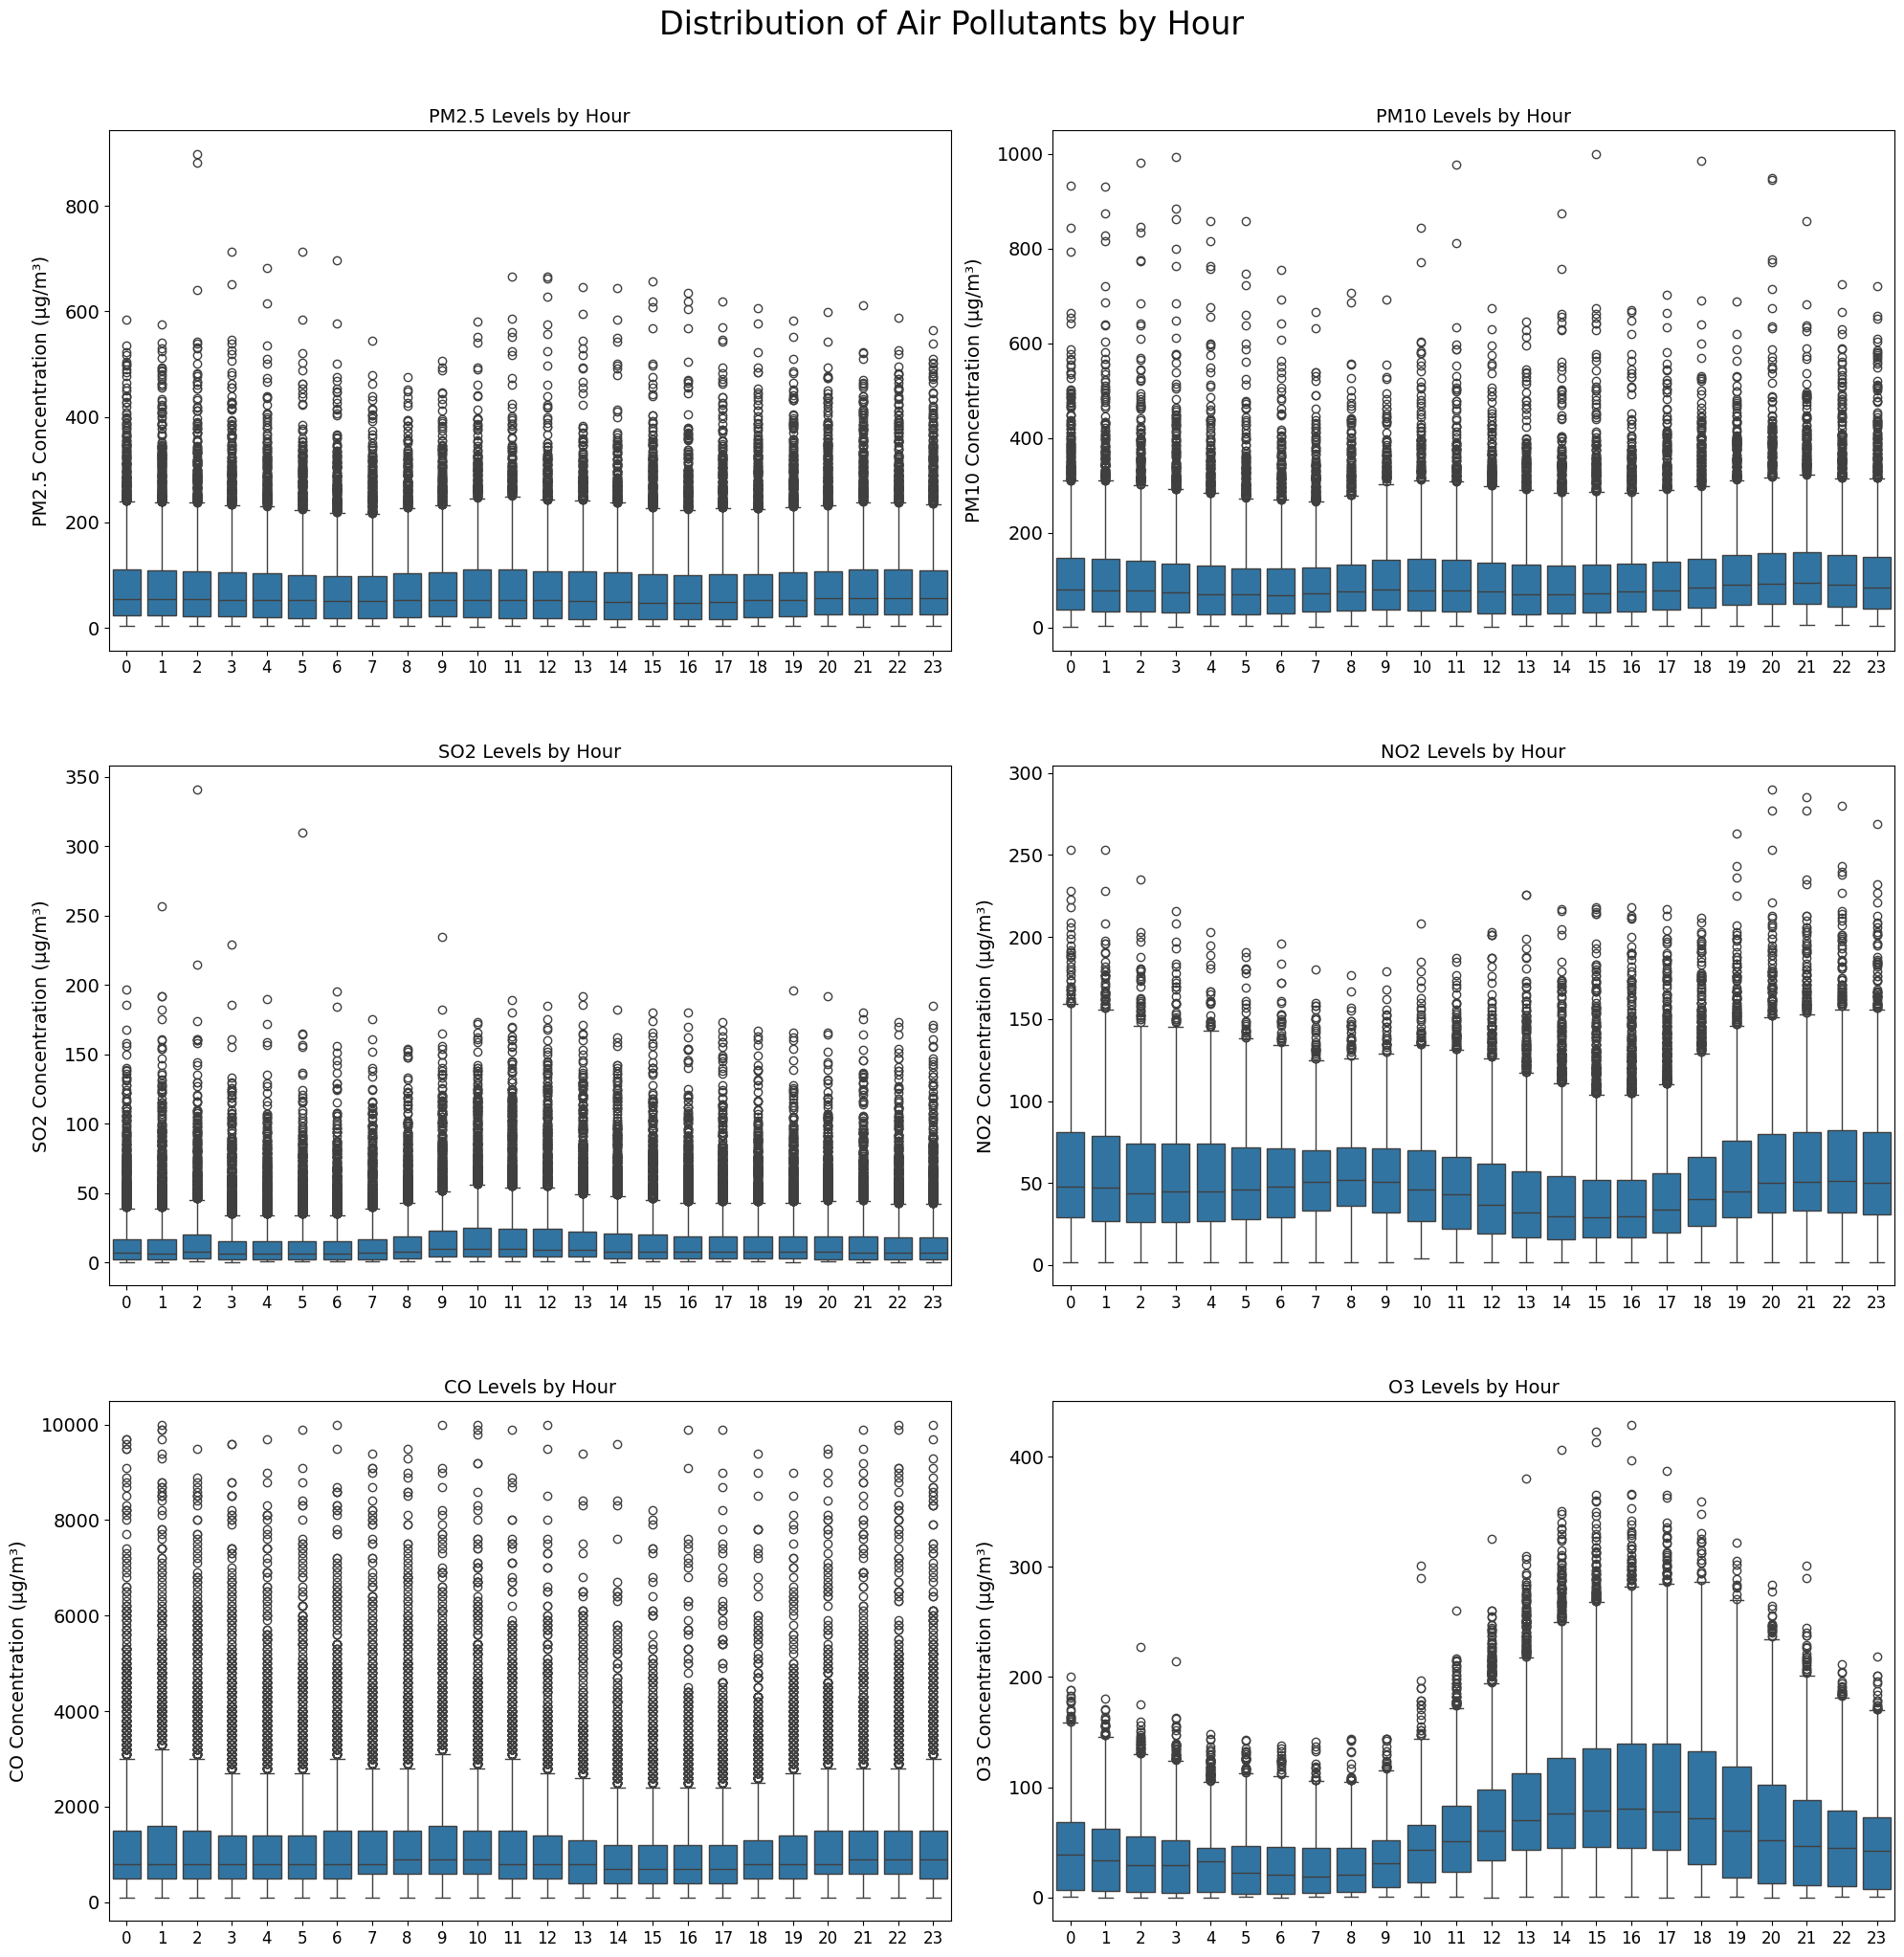

In [68]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='hour', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Hour', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Hour', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


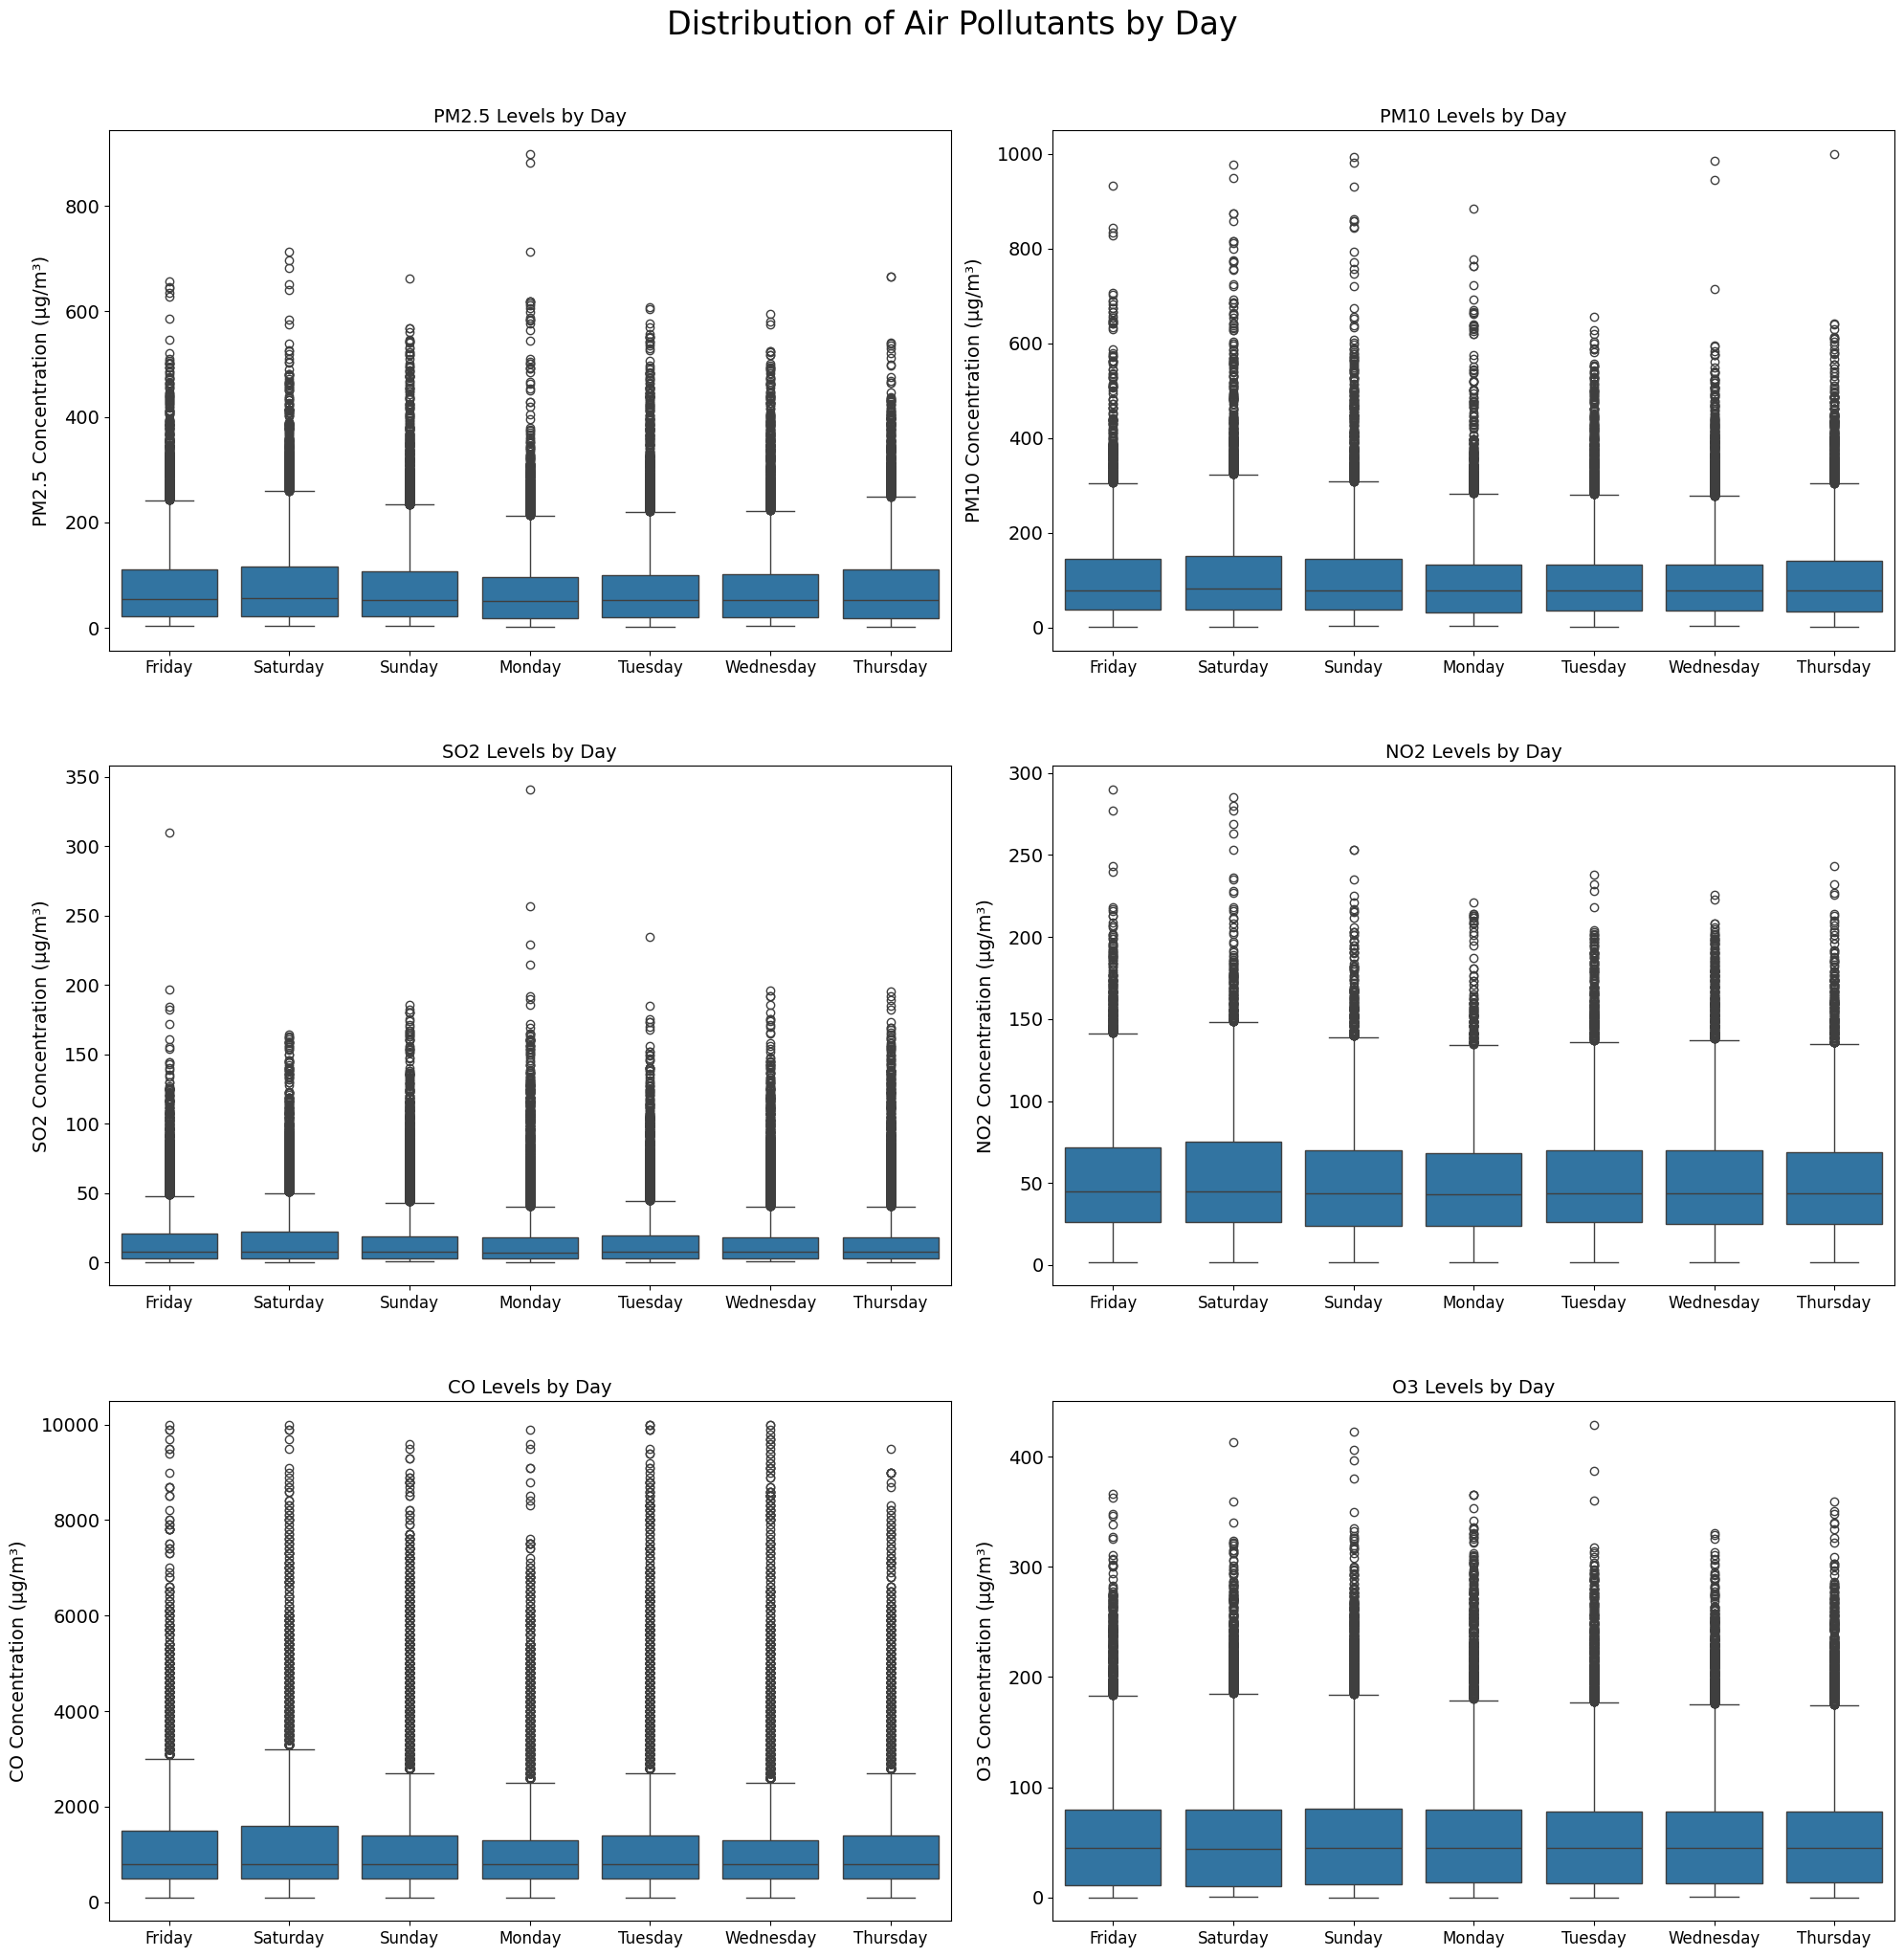

In [69]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='day_name', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Day', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Day', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


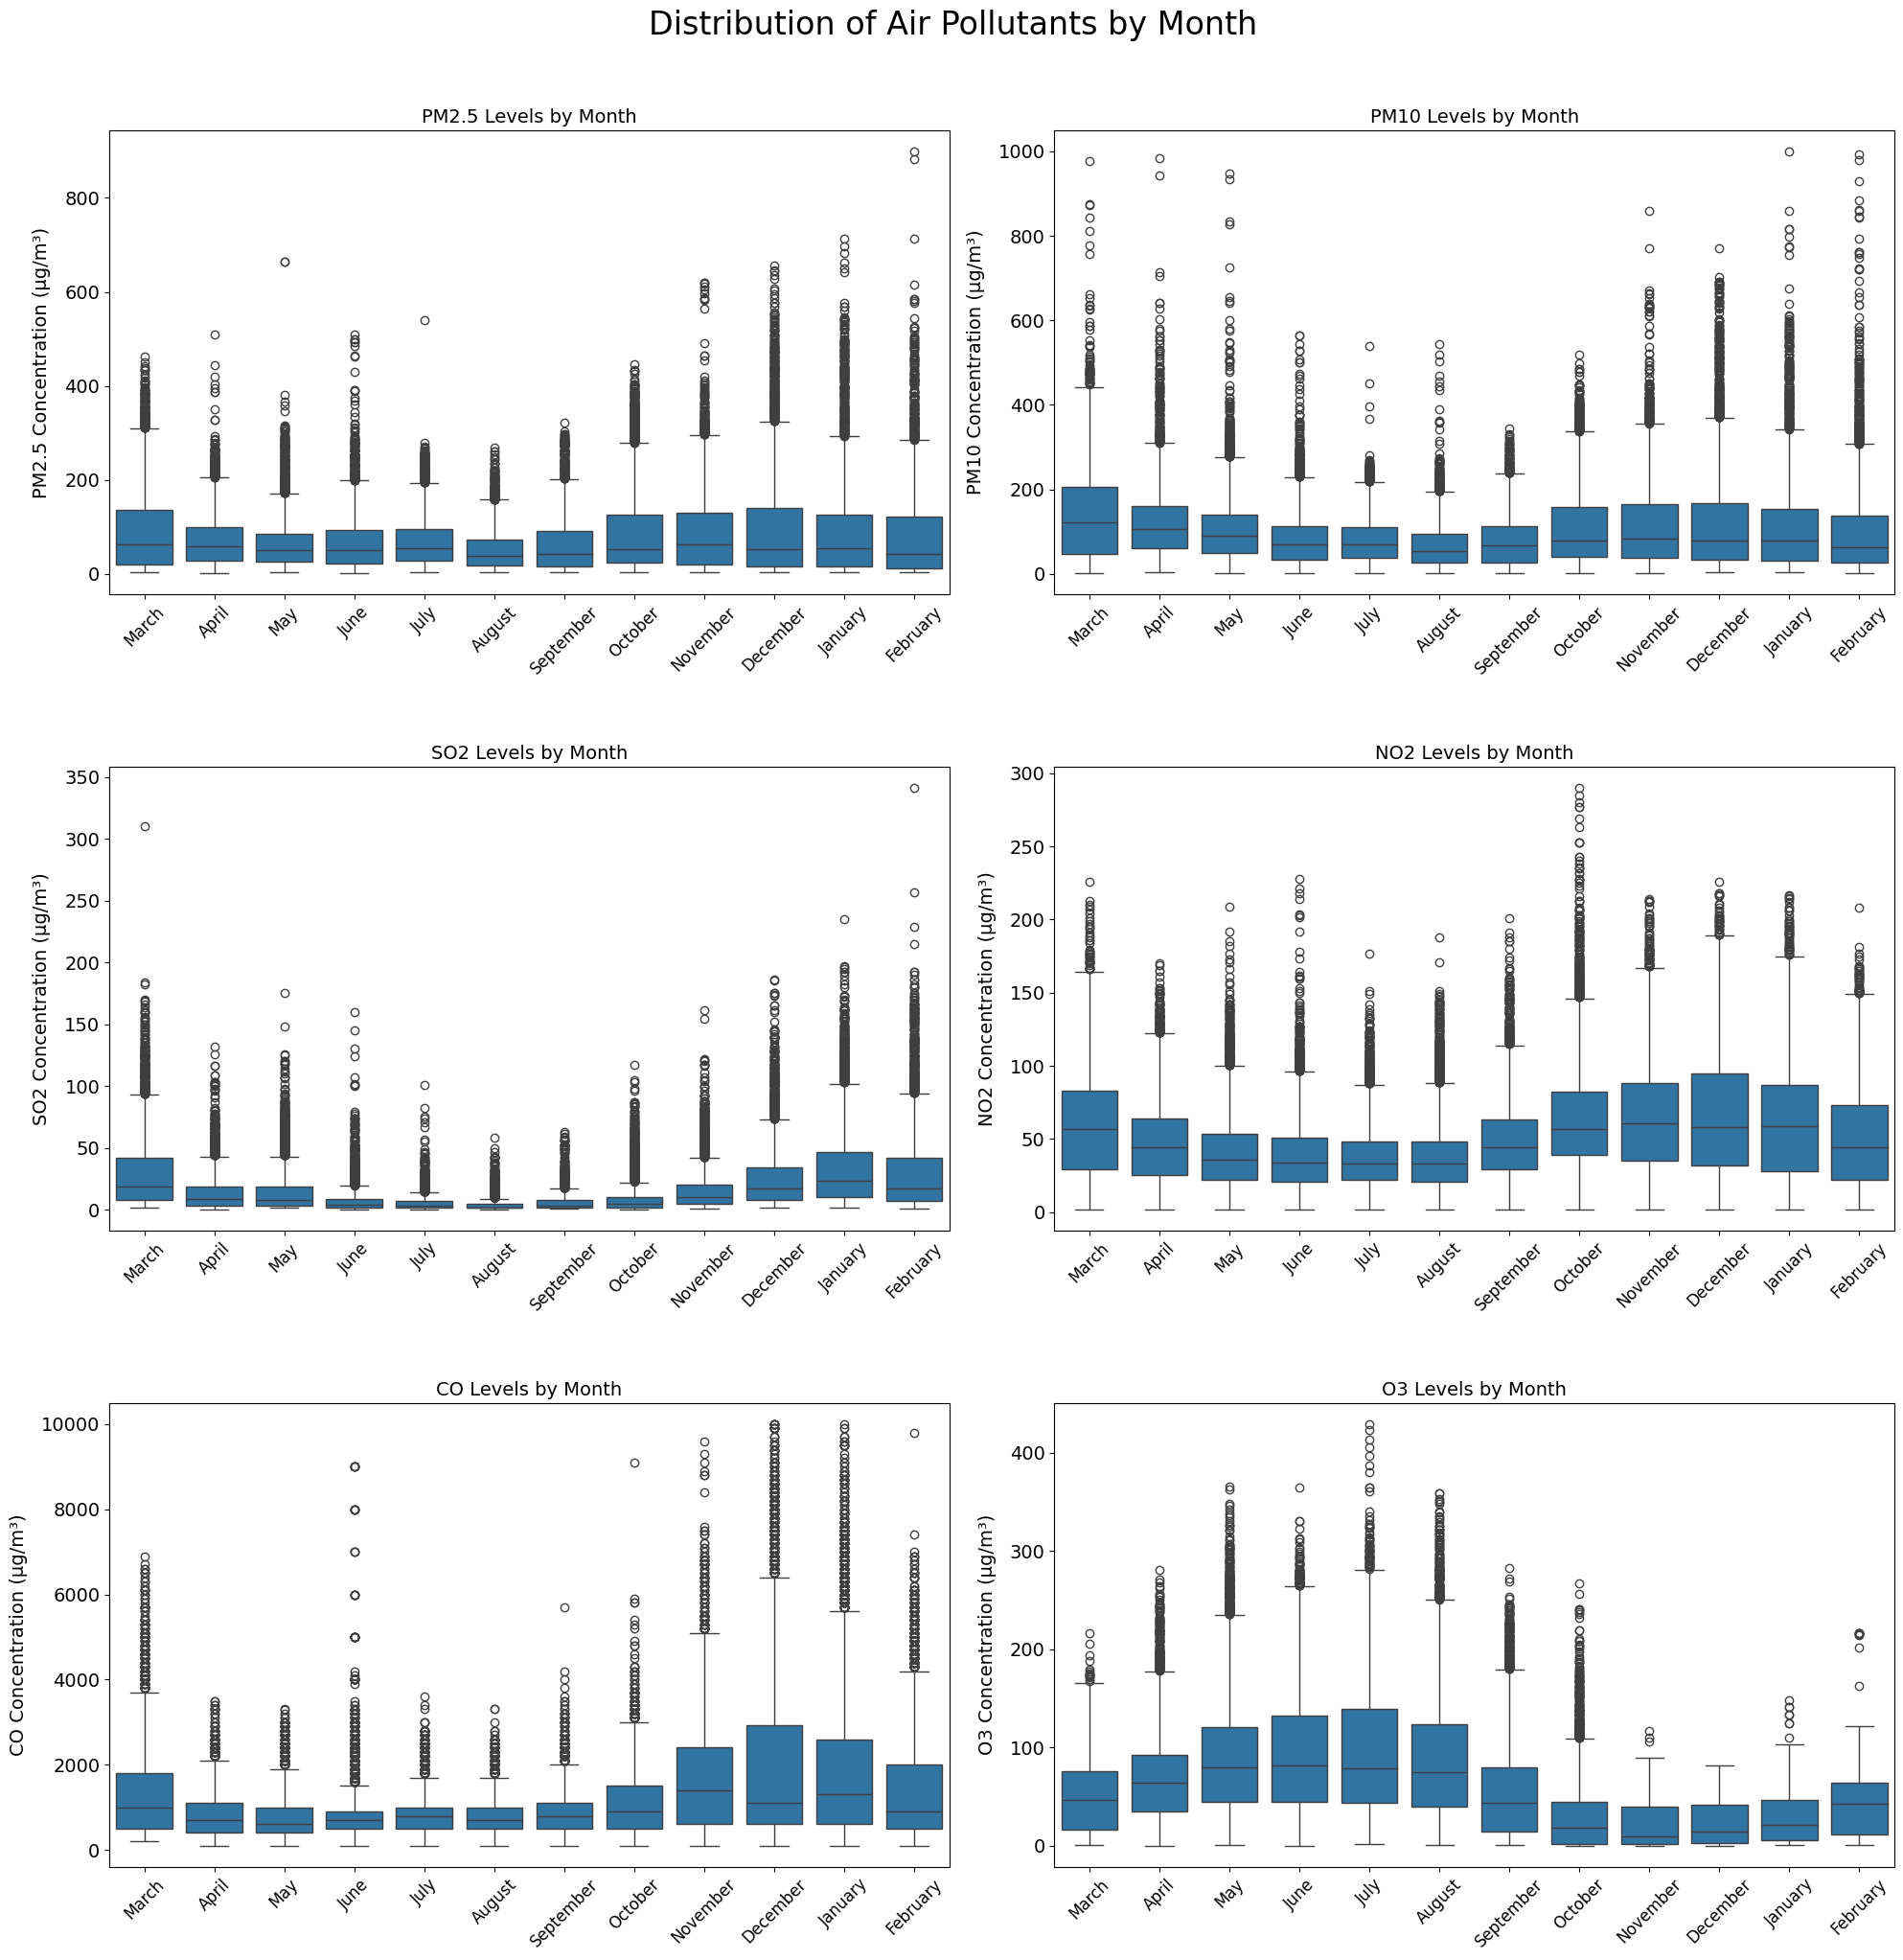

In [70]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='month_name', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Month', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Month', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


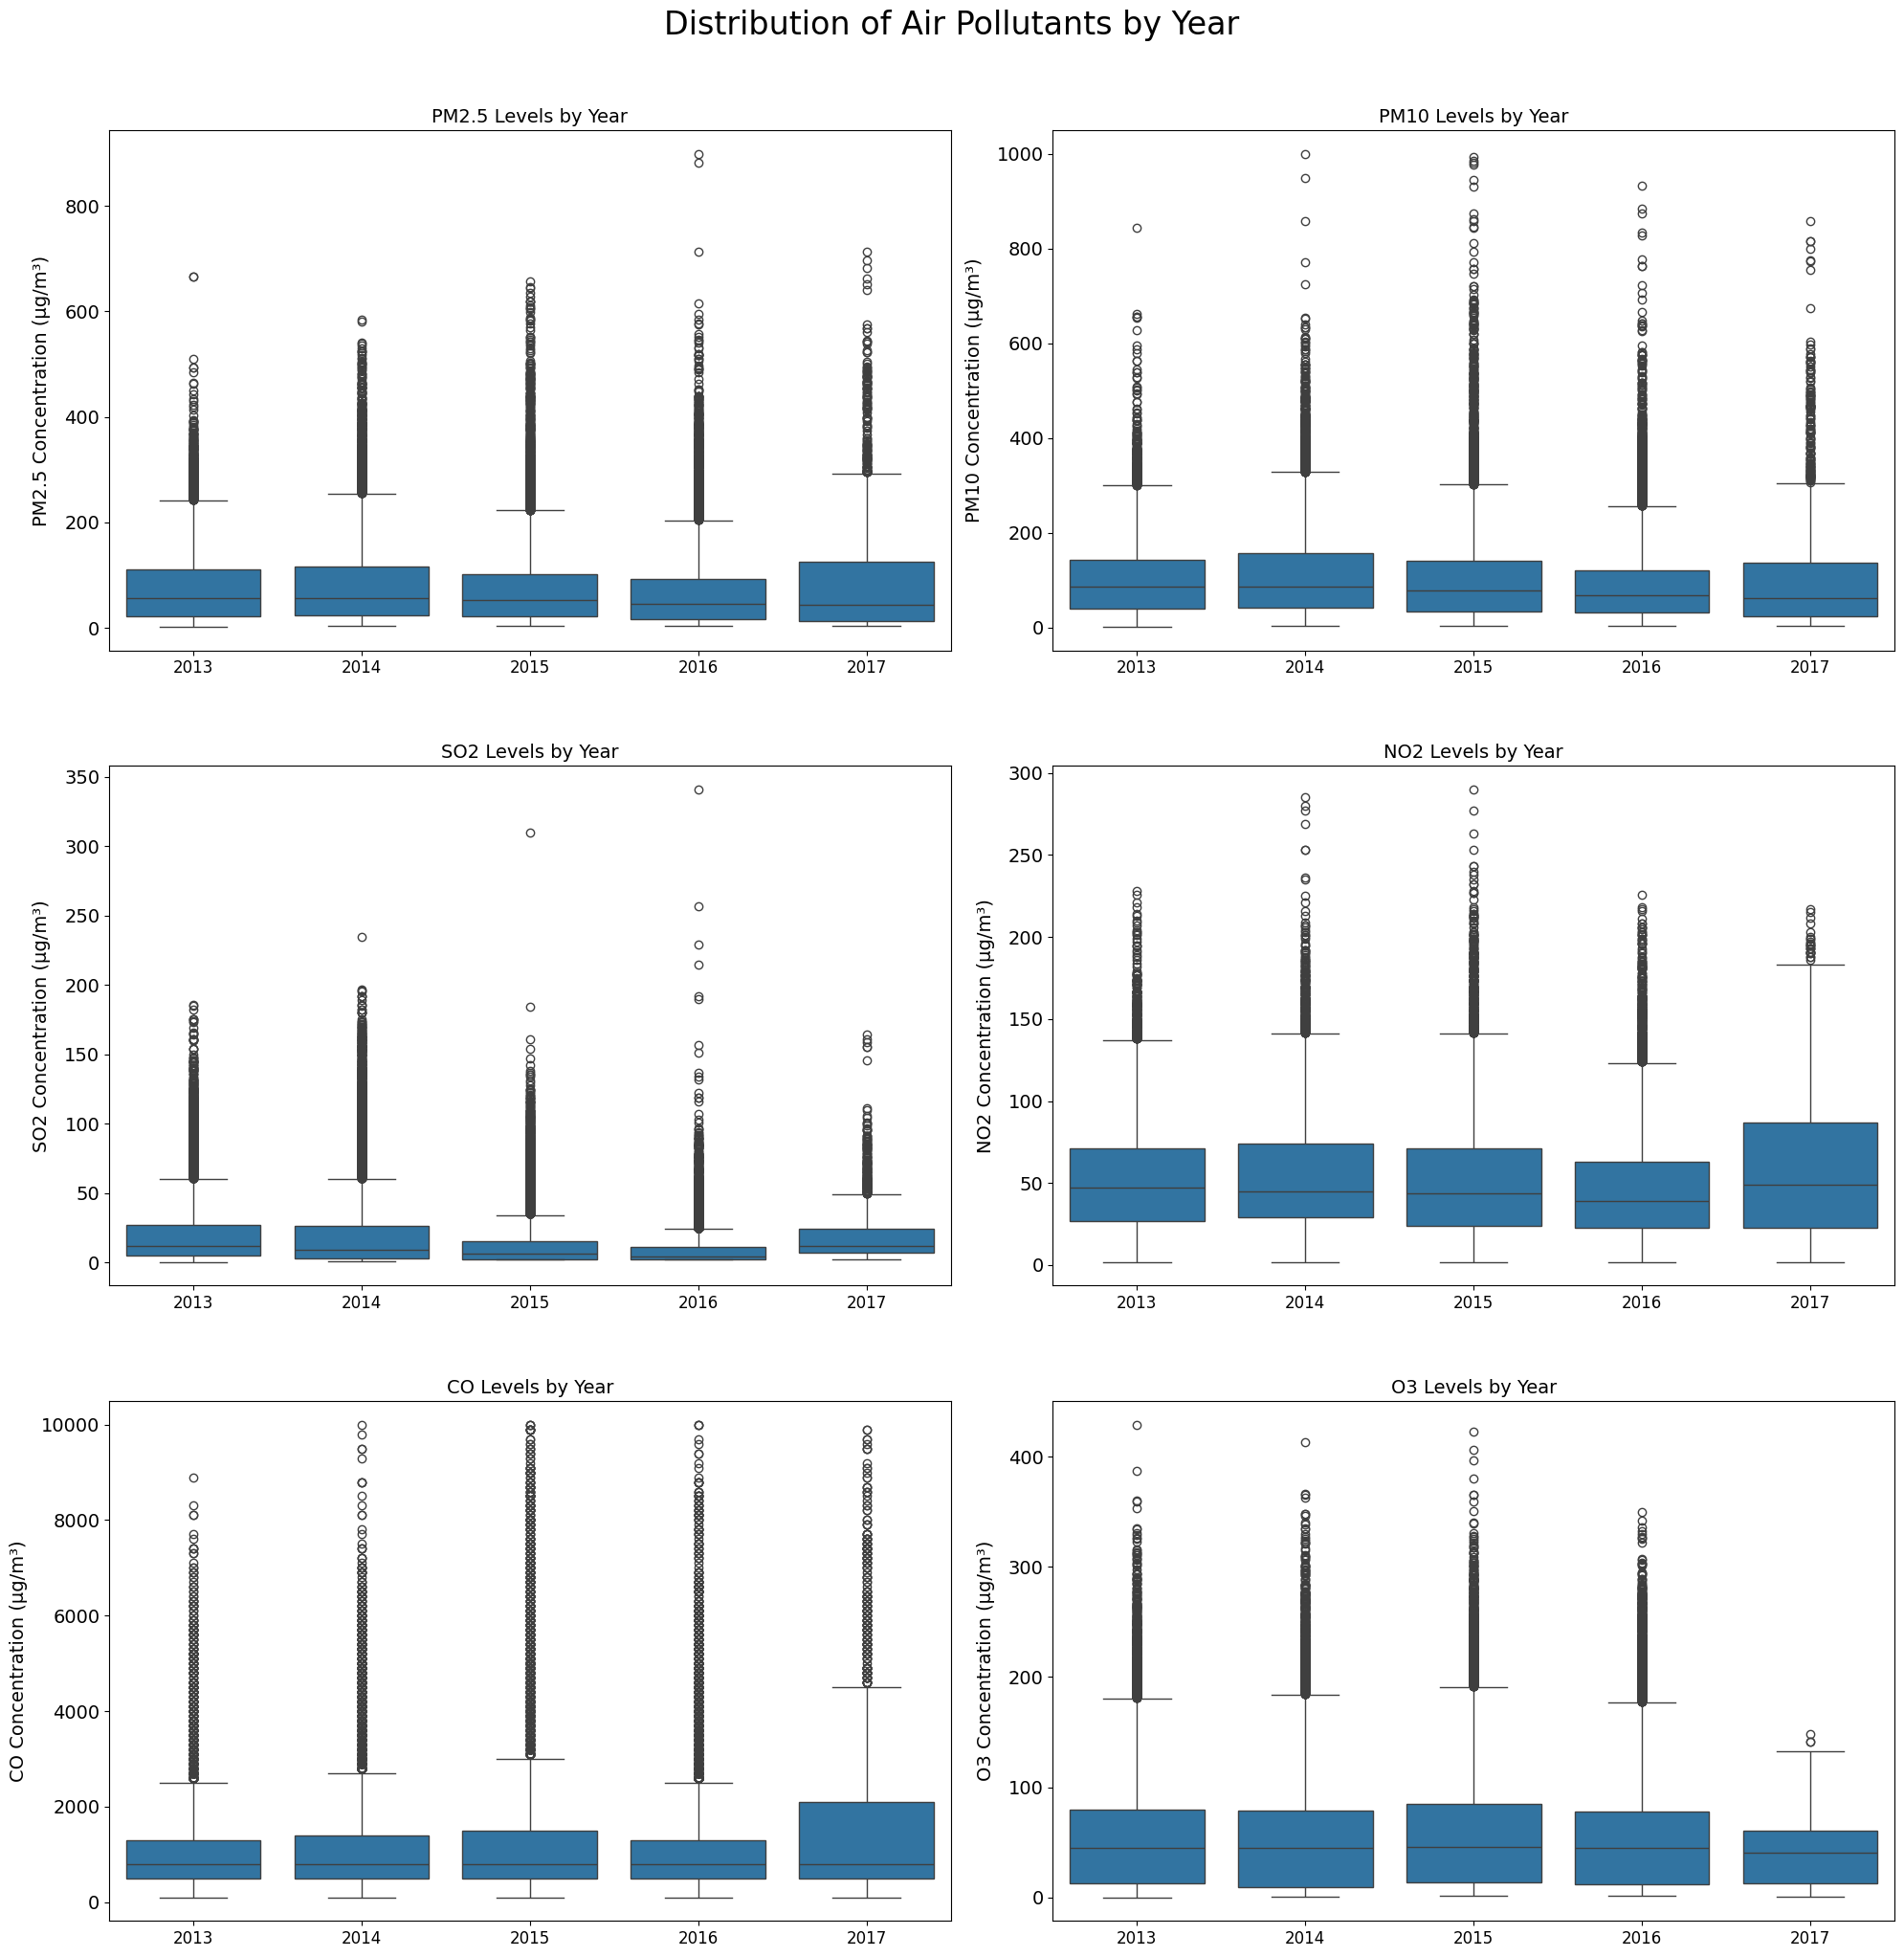

In [71]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='year', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Year', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Year', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


## 3. Summary Statistics

In [77]:
filtered_df[filtered_df.station=='Aotizhongxin'][parameters].describe()

,PM2.5,PM10,SO2,NO2,CO,O3
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,81.961793,109.424373,17.125888,58.859282,1239.496863,55.796764
std,81.194965,94.345610,22.567267,36.661350,1194.422306,56.531959
min,3.000000,2.000000,0.285600,2.000000,100.000000,0.214200
25%,23.000000,39.000000,3.000000,31.000000,500.000000,9.000000
50%,56.000000,84.000000,8.000000,52.000000,800.000000,45.000000
75%,112.000000,153.000000,21.000000,81.000000,1500.000000,80.000000
max,898.000000,984.000000,341.000000,290.000000,10000.000000,423.000000


In [98]:
filtered_df[filtered_df.station=='Changping'][parameters].describe()

,PM2.5,PM10,SO2,NO2,CO,O3
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,70.678137,94.397978,14.834271,44.178622,1137.019279,57.717103
std,71.579210,82.770507,20.807121,29.237683,1081.250627,53.873125
min,2.000000,2.000000,0.285600,1.847700,100.000000,0.214200
25%,18.000000,34.000000,2.000000,22.000000,500.000000,16.000000
50%,48.000000,74.000000,7.000000,37.000000,800.000000,45.000000
75%,98.000000,129.000000,18.000000,60.000000,1400.000000,79.000000
max,882.000000,999.000000,310.000000,226.000000,10000.000000,429.000000


## Time Series Plots

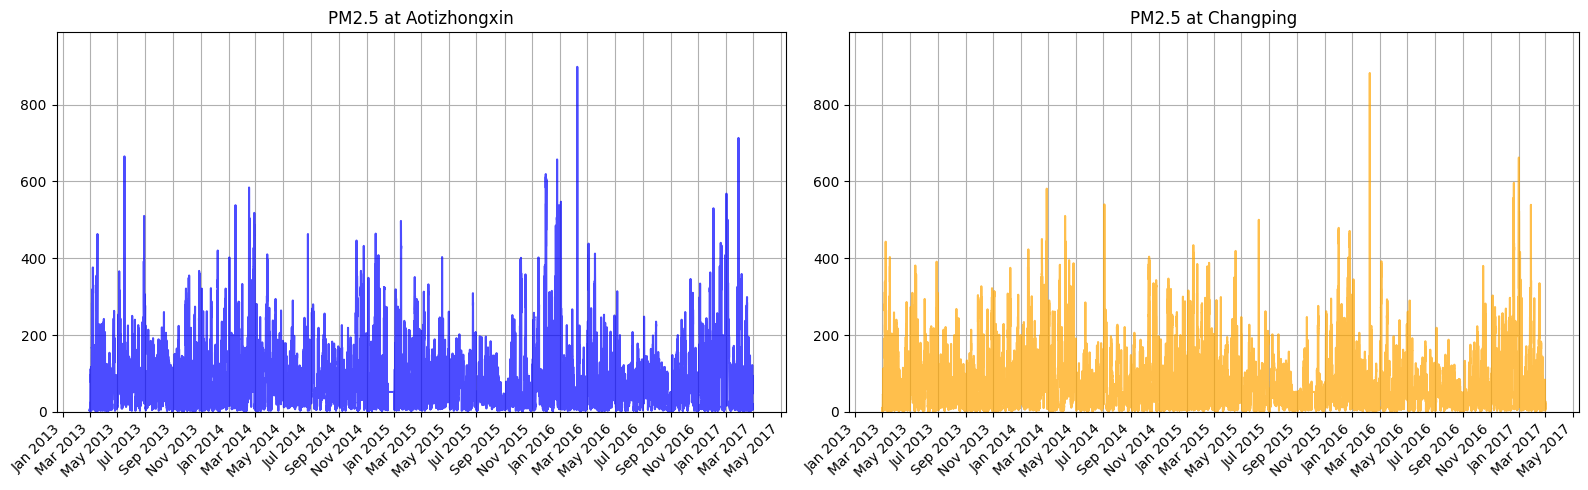

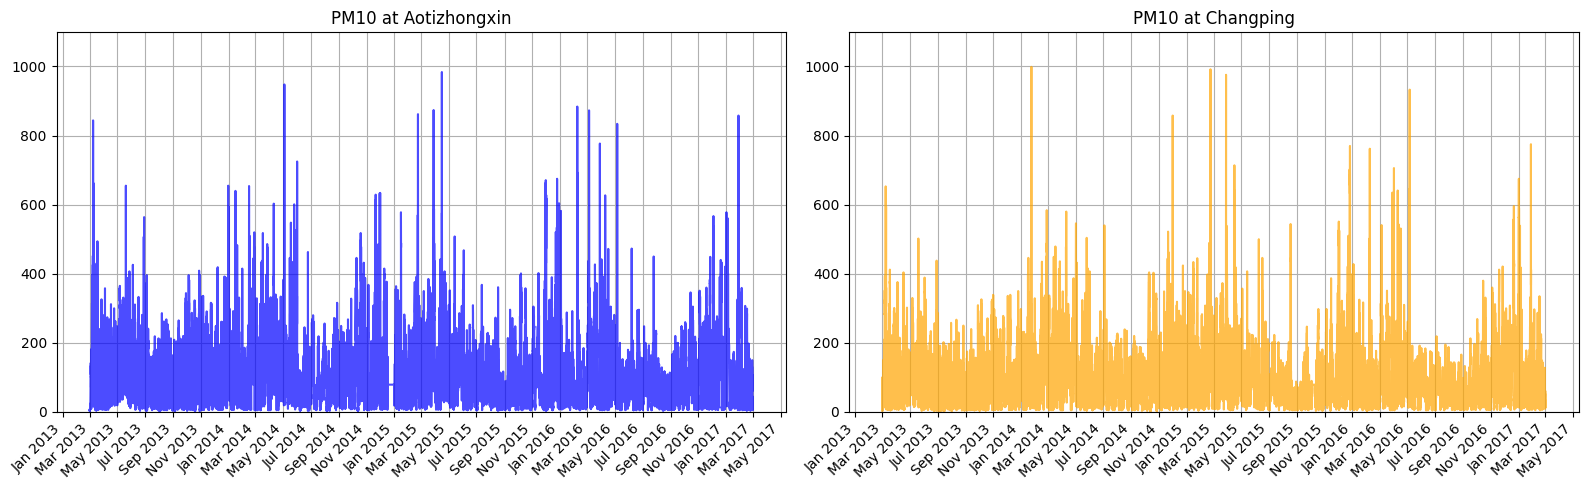

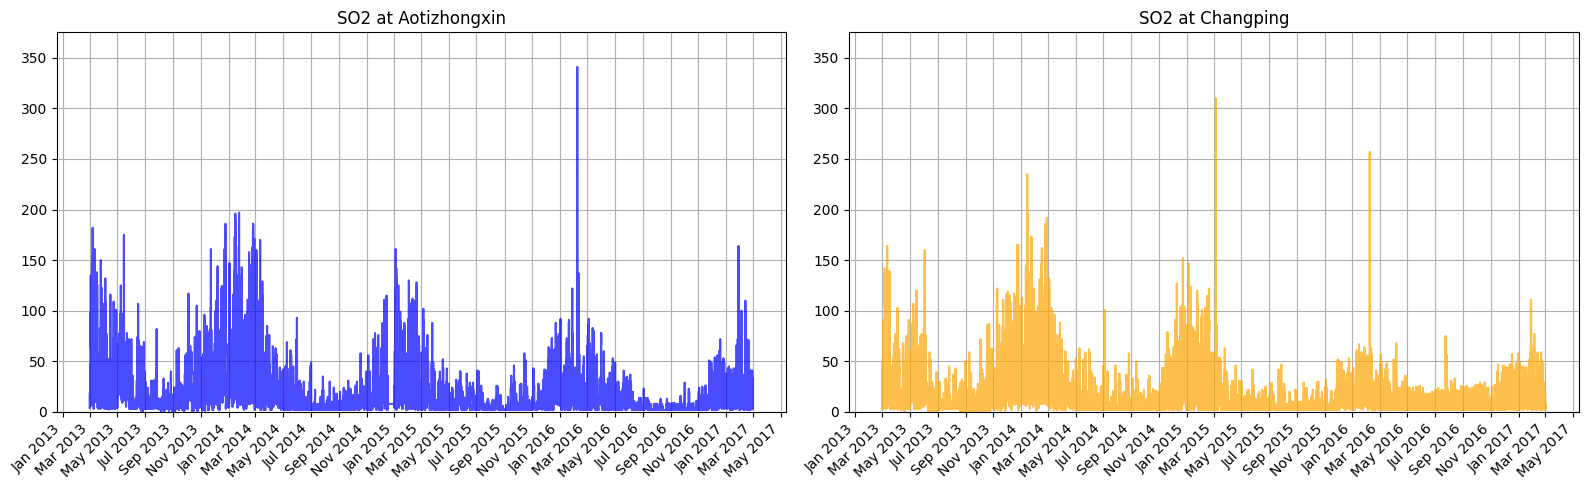

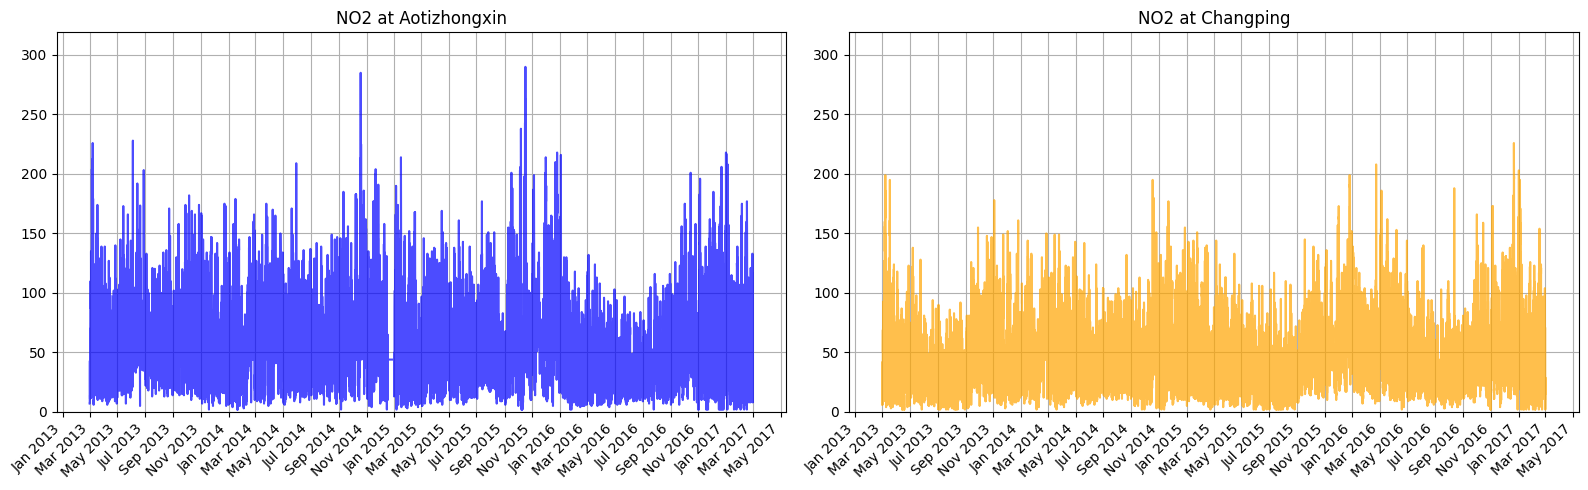

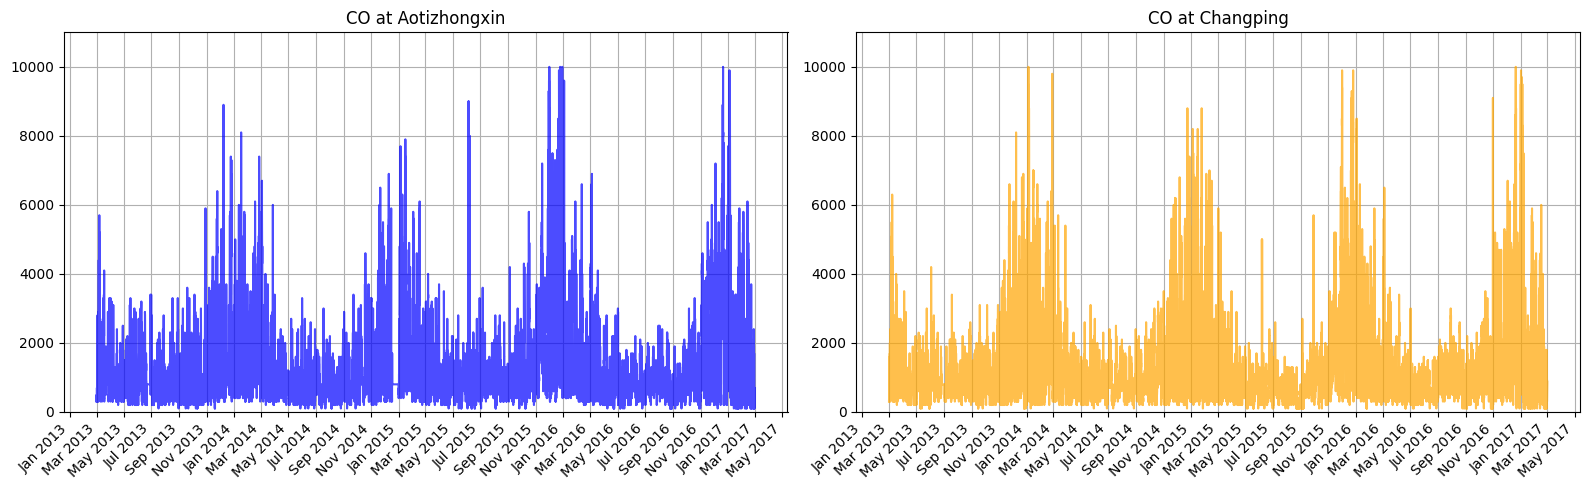

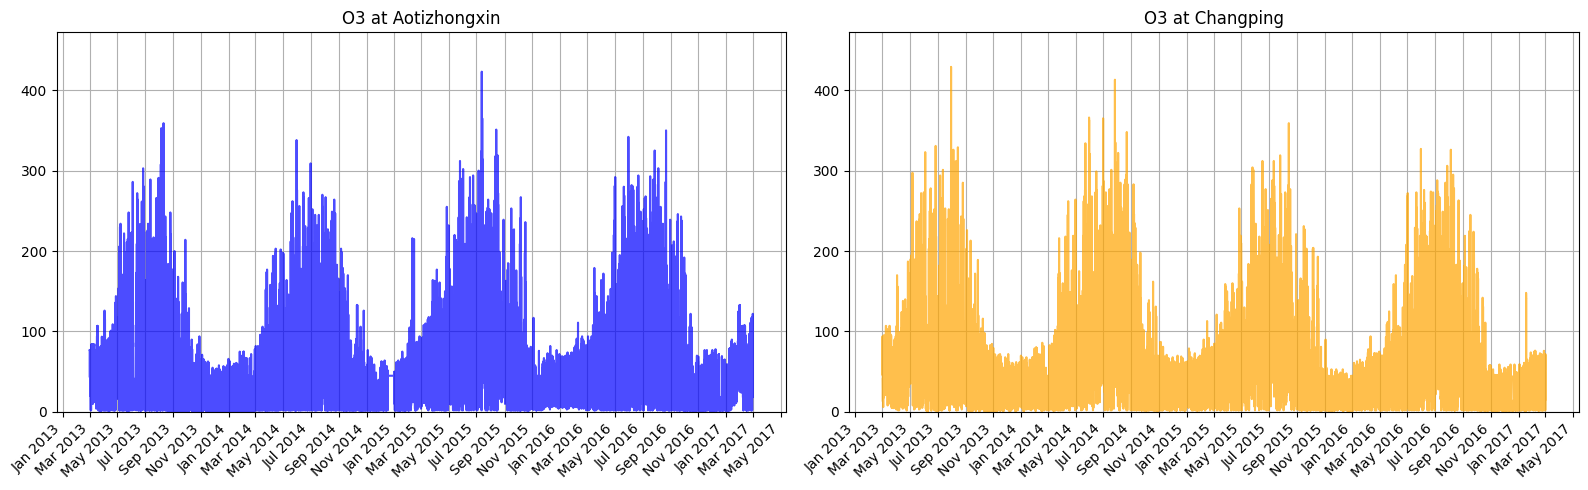

In [35]:
stations = filtered_df['station'].unique()

colors = {stations[0]: 'blue', stations[1]: 'orange'}


def plot_parameter(parameter):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), sharex=True)
    
    # Find the global maximum for the y-axis limit (for comparison)
    global_max = filtered_df[parameter].max()
    
    for j, station in enumerate(stations):
        station_data = filtered_df[filtered_df['station'] == station]
        
        axes[j].plot(station_data['timestamp'], station_data[parameter], 
                     color=colors[station], alpha=0.7, label=station)
        
        axes[j].set_title(f'{parameter} at {station}')
        axes[j].grid()
        
        # Set y-axis to be the same for both stations (using the max value)
        axes[j].set_ylim(0, global_max * 1.1)  # Adding 10% buffer for better visualization
    

    # Set x-ticks for all subplots to show every 2 months with 'Month Year' format
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

for parameter in parameters:
    plot_parameter(parameter)

## Histograms

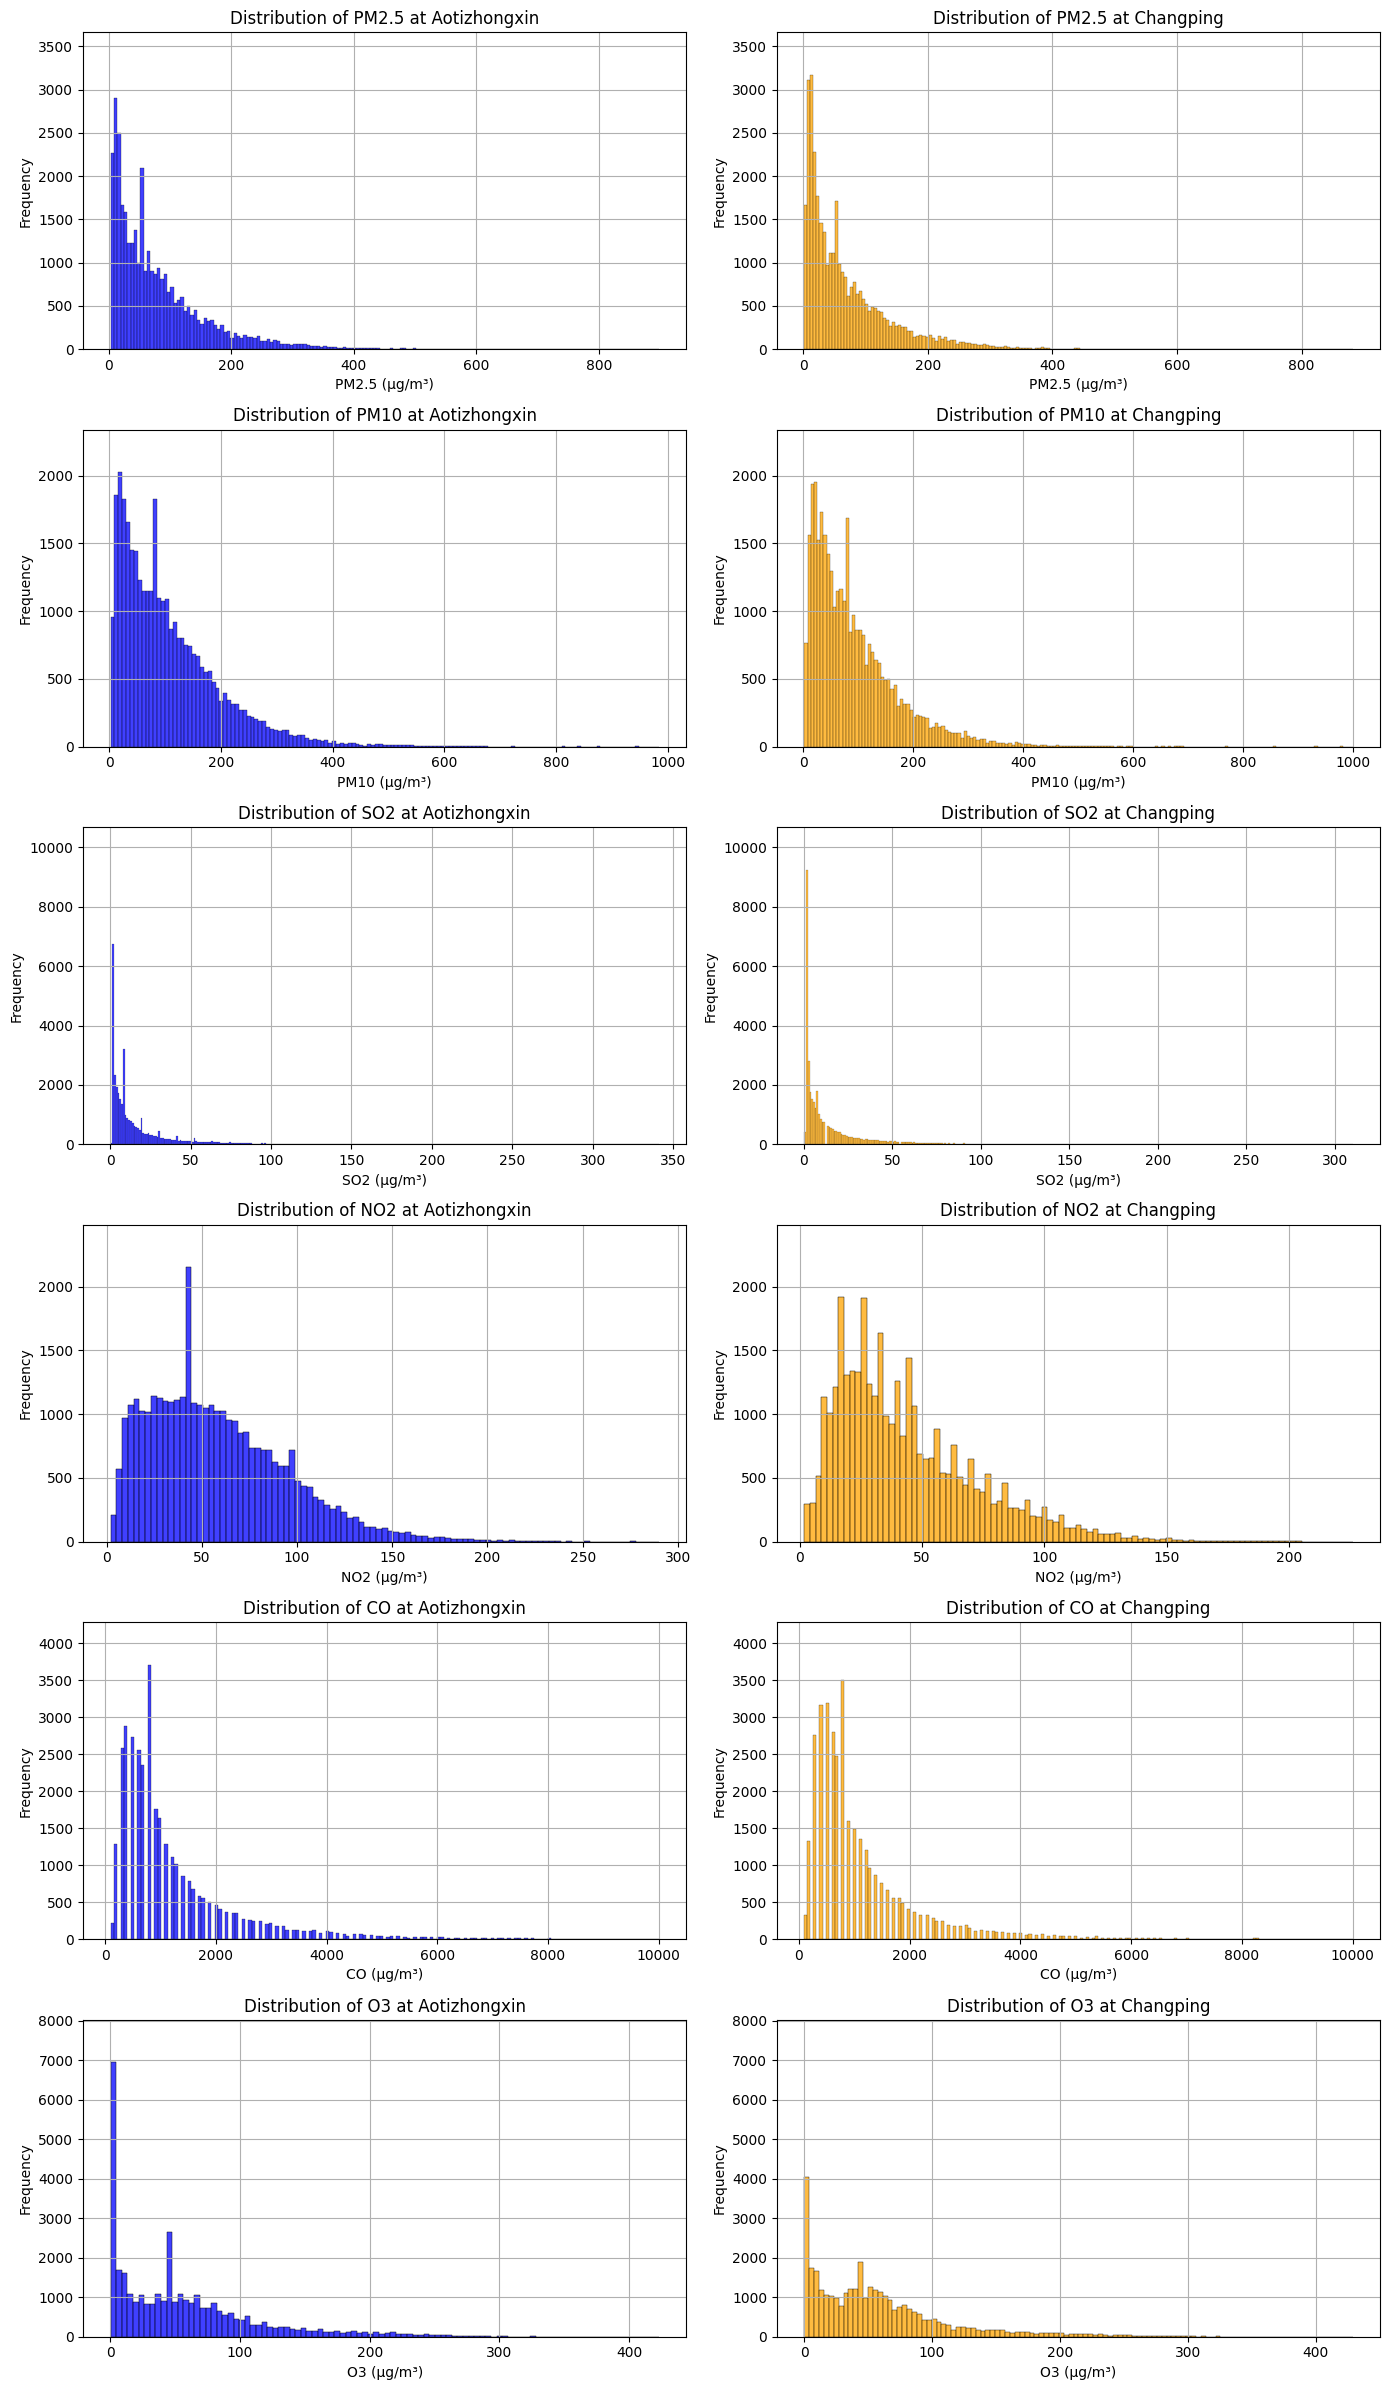

In [19]:
# Create subplots
fig, axes = plt.subplots(len(parameters), 2, figsize=(14, 4 * len(parameters)))

# Loop through each parameter and create histograms for each station
for i, parameter in enumerate(parameters):
    
    for j, station in enumerate(stations):
        station_data = filtered_df[filtered_df['station'] == station]
        
        # Plot the histogram 
        sns.histplot(station_data[parameter], bins='auto', ax=axes[i, j],
                     color='blue' if station == 'Aotizhongxin' else 'orange')
        
        # Set titles and labels
        axes[i, j].set_title(f'Distribution of {parameter} at {station}')
        axes[i, j].set_xlabel(f'{parameter} (µg/m³)')  

        axes[i, j].set_ylabel('Frequency')
        axes[i, j].grid(True)
    
    # Retrieve the max y-limit from both subplots for the current parameter
    max_y_value = max(axes[i, 0].get_ylim()[1], axes[i, 1].get_ylim()[1])
    
    # Set the same y-axis limit for both subplots for consistency
    axes[i, 0].set_ylim(0, max_y_value * 1.1)  # Add a 10% buffer
    axes[i, 1].set_ylim(0, max_y_value * 1.1)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


## Correlation Analysis

In [21]:
def correlation_analysis(station_data, parameters):
   
    # Calculate the correlation matrix
    correlation_matrix = station_data[parameters].corr(method='pearson')

    # Calculate p-values for each correlation
    p_values = pd.DataFrame(index=parameters, columns=parameters)
    
    for i in parameters:
        for j in parameters:
            if i != j:
                # Calculate the correlation and p-value
                corr_coef, p_value = stats.pearsonr(station_data[i], station_data[j])
                p_values.loc[i, j] = p_value
            else:
                p_values.loc[i, j] = None  # No p-value for self-correlation
    
    return correlation_matrix, p_values

In [67]:
def visualize_correlation_matrix(correlation_matrix, station):
    
    
    # Mask for the upper triangle (exclude the diagonal)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

    # Create the heatmap
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm',  
                mask=mask,  
                cbar_kws={"shrink": 1}, 
                linewidths=0.5, 
                linecolor='white',  
                square=True,  
                vmax=1, 
                vmin=-1)  

    # Titles and labels
    plt.title(f'Correlation Matrix for {station}', pad=30)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Improve layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

#### Aotizhongxin Station

In [68]:
station_A = stations[0]
correlation_matrix_A, p_values_A = correlation_analysis(filtered_df[filtered_df.station==station_A], parameters)
# Print the results for the current station
print(f"\nCorrelation Matrix for {station_A}:")
print(correlation_matrix_A)

print(f"\nP-Values Matrix for {station_A}:")
print(p_values_A)


Correlation Matrix for Aotizhongxin:
          PM2.5      PM10       SO2       NO2        CO        O3
PM2.5  1.000000  0.873792  0.477797  0.676940  0.752530 -0.158324
PM10   0.873792  1.000000  0.465419  0.647106  0.654749 -0.137282
SO2    0.477797  0.465419  1.000000  0.431587  0.528280 -0.195531
NO2    0.676940  0.647106  0.431587  1.000000  0.672922 -0.489528
CO     0.752530  0.654749  0.528280  0.672922  1.000000 -0.316873
O3    -0.158324 -0.137282 -0.195531 -0.489528 -0.316873  1.000000

P-Values Matrix for Aotizhongxin:
      PM2.5  PM10   SO2   NO2    CO    O3
PM2.5  None   0.0   0.0   0.0   0.0   0.0
PM10    0.0  None   0.0   0.0   0.0   0.0
SO2     0.0   0.0  None   0.0   0.0   0.0
NO2     0.0   0.0   0.0  None   0.0   0.0
CO      0.0   0.0   0.0   0.0  None   0.0
O3      0.0   0.0   0.0   0.0   0.0  None


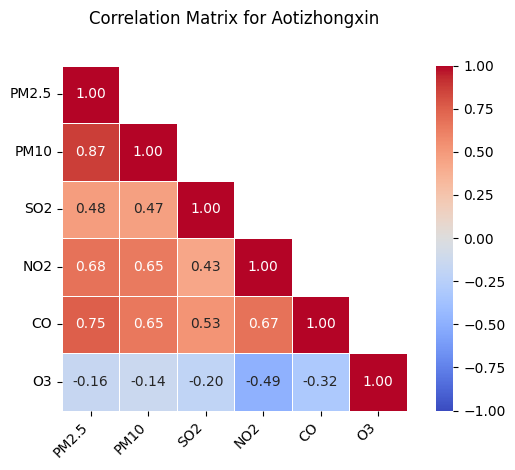

In [69]:
visualize_correlation_matrix(correlation_matrix_A, station_A)

#### Changping Station

In [72]:
station_B = stations[1]
correlation_matrix_B, p_values_B = correlation_analysis(filtered_df[filtered_df.station==station_B], parameters)
# Print the results for the current station
print(f"\nCorrelation Matrix for {station_B}:")
print(correlation_matrix_B)

print(f"\nP-Values Matrix for {station_B}:")
print(p_values_B)


Correlation Matrix for Changping:
          PM2.5      PM10       SO2       NO2        CO        O3
PM2.5  1.000000  0.857973  0.452676  0.668465  0.737815 -0.097685
PM10   0.857973  1.000000  0.419772  0.630990  0.655608 -0.049731
SO2    0.452676  0.419772  1.000000  0.489400  0.519855 -0.186761
NO2    0.668465  0.630990  0.489400  1.000000  0.719173 -0.466800
CO     0.737815  0.655608  0.519855  0.719173  1.000000 -0.301360
O3    -0.097685 -0.049731 -0.186761 -0.466800 -0.301360  1.000000

P-Values Matrix for Changping:
      PM2.5  PM10   SO2   NO2    CO    O3
PM2.5  None   0.0   0.0   0.0   0.0   0.0
PM10    0.0  None   0.0   0.0   0.0   0.0
SO2     0.0   0.0  None   0.0   0.0   0.0
NO2     0.0   0.0   0.0  None   0.0   0.0
CO      0.0   0.0   0.0   0.0  None   0.0
O3      0.0   0.0   0.0   0.0   0.0  None


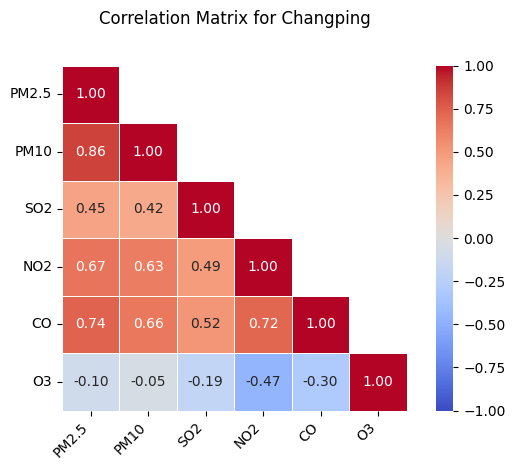

In [73]:
visualize_correlation_matrix(correlation_matrix_B, station_B)

In [76]:
def correlation_analysis_and_visualization(df, station1, station2, parameters):
    # Initialize dictionaries to store correlation coefficients and p-values
    corr_coeffs = {}
    p_values = {}

    for parameter in parameters:
        # Filter data for each station
        data_station1 = df[df['station'] == station1][parameter]
        data_station2 = df[df['station'] == station2][parameter]

        # Calculate the Pearson correlation coefficient and p-value
        correlation_coefficient, p_value = stats.pearsonr(data_station1, data_station2)

        # Store results
        corr_coeffs[parameter] = correlation_coefficient
        p_values[parameter] = p_value

    # Create DataFrames for correlation coefficients and p-values
    corr_df = pd.DataFrame.from_dict(corr_coeffs, orient='index', columns=['Correlation Coefficient'])
    pval_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['P-Value'])

    # Combine both DataFrames
    result_df = pd.concat([corr_df, pval_df], axis=1)

    # Display the results
    print(result_df)

    
# Example usage
correlation_analysis_and_visualization(filtered_df, station_A, station_B, parameters)

       Correlation Coefficient  P-Value
PM2.5                 0.835166      0.0
PM10                  0.796250      0.0
SO2                   0.796430      0.0
NO2                   0.644885      0.0
CO                    0.734179      0.0
O3                    0.859645      0.0


## Trend Analysis

## Reporting